**1. Import libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from numpy import exp, array, random, dot, linspace, zeros, asarray
from keras.layers import Dense, Input
from keras.models import Sequential, Model
from keras.optimizers import Adam

from scipy.integrate import solve_ivp, odeint
from scipy.optimize  import minimize

**2. Read data from CSSEGISandData/COVID-19**

In [ ]:
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url_death = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
url_recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
        
cases_glob_df  = pd.read_csv(url_confirmed)
deaths_glob_df = pd.read_csv(url_death)
recovs_glob_df = pd.read_csv(url_recovered)

In [ ]:
#test
cases_glob_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,29481,29640,30175,30451,30616,30967,31238,31517,31836,32022,32324,32672,32951,33190,33384,33594,33908,34194,34366,34451,34455,34740,34994,35070,35229,35301,35475,35526,35615,35727,35928,35981,36036,36157,36263,36368,36471,36542,36675,36710
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2047,2114,2192,2269,2330,2402,2466,2535,2580,2662,2752,2819,2893,2964,3038,3106,3188,3278,3371,3454,3571,3667,3752,3851,3906,4008,4090,4171,4290,4358,4466,4570,4637,4763,4880,4997,5105,5197,5276,5396
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,12076,12248,12445,12685,12968,13273,13571,13907,14272,14657,15070,15500,15941,16404,16879,17348,17808,18242,18712,19195,19689,20216,20770,21355,21948,22549,23084,23691,24278,24872,25484,26159,26764,27357,27973,28615,29229,29831,30394,30950
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,858,861,862,877,880,880,880,884,884,889,889,897,897,897,907,907,918,922,925,925
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,189,197,212,212,259,267,276,284,291,315,328,346,346,346,386,386,396,458,462,506,525,541,576,607,638,687,705,749,779,812,851,880,916,932,950,1000,1078,1109,1148,1164


**3. Filter out the data in US only**

In [ ]:
location = "US"
# get population from worldometer
population = 331002651

In [ ]:
cases_df = cases_glob_df.loc[cases_glob_df['Country/Region'] == location].loc[cases_glob_df['Province/State'].isnull()]
death_df = deaths_glob_df.loc[deaths_glob_df['Country/Region'] == location].loc[deaths_glob_df['Province/State'].isnull()]
recovered_df = recovs_glob_df.loc[recovs_glob_df['Country/Region'] == location].loc[recovs_glob_df['Province/State'].isnull()]

In [ ]:
#test
cases_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20
225,NaN,US,40.0,-100.0,1,1,2,2,5,5,5,5,5,7,8,8,11,11,11,11,11,11,11,11,12,12,13,13,13,13,13,13,13,13,15,15,15,15,15,15,...,2347491,2382426,2422299,2467554,2510259,2549864,2590668,2636414,2687588,2742049,2795361,2841241,2891124,2936077,2996098,3054699,3117946,3185737,3245925,3304942,3364157,3431574,3498902,3576157,3647715,3711413,3773260,3834677,3899211,3970121,4038816,4112531,4178970,4233923,4290337,4356206,4426982,4495015,4562038,4620444


In [ ]:
cases_df.drop(labels=['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1, inplace =True)
death_df.drop(labels=['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1, inplace =True)
recovered_df.drop(labels=['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1, inplace =True)
case_df = cases_df.transpose()
death_df = death_df.transpose()
recovered_df = recovered_df.transpose()

In [ ]:
case_df.rename(columns = {case_df.columns[0]:'Cases'}, inplace=True)
death_df.rename(columns = {death_df.columns[0]:'Death'}, inplace=True)
recovered_df.rename(columns = {recovered_df.columns[0]:'Recovered'}, inplace=True)
data_df = pd.concat([case_df, death_df, recovered_df], axis=1,sort=False)
data_df['SIRD_Suspectible'] = population - data_df['Cases']
data_df['SIRD_Infected'] = data_df['Cases']-data_df['Death'] - data_df['Recovered']
data_df['SIRD_Recovered'] = data_df['Recovered']
data_df['SIRD_Death'] = data_df['Death']

SIRD_df = data_df.loc[:, data_df.columns.intersection(['SIRD_Suspectible', 'SIRD_Infected', 'SIRD_Recovered', 'SIRD_Death'])]
#test
SIRD_df

,SIRD_Suspectible,SIRD_Infected,SIRD_Recovered,SIRD_Death
1/22/20,331002650,1,0,0
1/23/20,331002650,1,0,0
1/24/20,331002649,2,0,0
1/25/20,331002649,2,0,0
1/26/20,331002646,5,0,0
...,...,...,...,...
7/28/20,326646445,2851469,1355363,149374
7/29/20,326575669,2886735,1389425,150822
7/30/20,326507636,2928805,1414155,152055
7/31/20,326440613,2970564,1438160,153314


**4. Build SIRD_model**

In [ ]:
def SIRD_model (y, t, beta, gamma, mu, pop):
    S, I, R, D = y
    dS_dt = (-beta*S*I)/pop
    dI_dt = (((beta*S*I)/pop) - (gamma*I)) - (mu*I)
    dR_dt = gamma*I
    dD_dt = mu*I
    return ([ dS_dt , dI_dt , dR_dt, dD_dt ])

**5. Build loss function (RMSE)**

In [ ]:
def RMSE(point, data, S0, I0, R0, D0, pop):
  beta, gamma, mu = point
  size = len(data)

  def SIRD(t, y):
    S = y[0]
    I = y[1]
    R = y[2]
    D = y[3]

    S_res = (-beta*S*I)/pop
    I_res = (beta*S*I/pop) - gamma*I - mu*I
    R_res = gamma*I
    D_res = mu*I

    return [S_res, I_res, R_res, D_res]
  
  solution = solve_ivp(SIRD, [0, size], [S0, I0, R0, D0], t_eval = np.arange(0, size, 1), vectorized = True)
  
  l0 = np.sqrt(np.mean((solution.y[0]-data['SIRD_Suspectible'])**2))
  l1 = np.sqrt(np.mean((solution.y[1]-data['SIRD_Infected'])**2))
  l2 = np.sqrt(np.mean((solution.y[2]-data['SIRD_Recovered'])**2))
  l3 = np.sqrt(np.mean((solution.y[3]-data['SIRD_Death'])**2))

  return 0.25*l0 + 0.25*l1 + 0.25*l2 + 0.25*l3

**6. Train and predict SIRD**

In [ ]:
def trainSIRD(country_data, population, S0, I0, R0, D0):
  optimal = minimize(RMSE, [0.0001, 0.0001, 0.0001], args = (country_data, S0, I0, R0, D0, population), method = 'L-BFGS-B', bounds= [(0.000001, 0.4), (0.000001, 0.4), (0.000001, 0.4)] )
  beta, gamma, mu = optimal.x
  return beta, gamma, mu

In [ ]:
def train_test_split_df(data, trainSize):
  num_rows = data.shape[0] 
  num_train_rows = num_rows*trainSize//100
  num_test_rows = num_rows - num_train_rows

  train_data = data.iloc[ :num_train_rows, :]
  test_data = data.iloc[num_train_rows:, :]
  return train_data, test_data

In [ ]:
def predictSIRD(data, beta, gamma, mu, S0, I0, R0, D0, pop):
  time = data.shape[0]
  t = np.linspace(1,time,10000)
  solution = odeint(SIRD_model, [S0, I0, R0, D0], t, args= (beta, gamma, mu, pop))
  solution = np.array(solution)
  return solution

**7. Implementation**

In [ ]:
SIRD_init = list(SIRD_df.iloc[2, :])
print(SIRD_init)
S0 = SIRD_init[0]
I0 = SIRD_init[1]
R0 = SIRD_init[2]
D0 = SIRD_init[3]

[331002649, 2, 0, 0]


In [ ]:
train_data, test_data = train_test_split_df(SIRD_df, 99)
Beta, Gamma, Mu = trainSIRD(train_data, population, S0, I0, R0, D0)
print('Beta = ',Beta)
print('Gamma = ',Gamma)
print('Mu = ', Mu)

Beta =  0.11995893364421482
Gamma =  0.03804067192756672
Mu =  0.004789802899428518


**8. Plot the result of S,I,R,D Comparision**

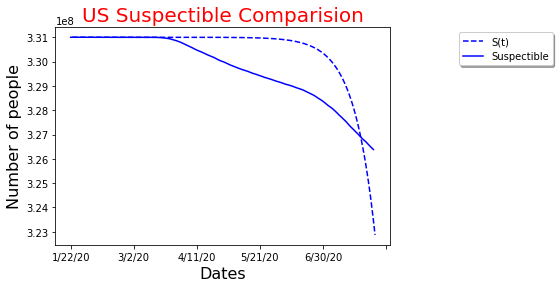

In [ ]:
solution = predictSIRD(SIRD_df, Beta, Gamma, Mu , S0, I0, R0, D0, population)
time = SIRD_df.shape[0]
t = np.linspace(1,time,10000)
x_val = [0, 40, 80, 120, 160, 200]
plt.plot(t, solution[:, 0], '--', label ='S(t)', color = 'blue')
plt.plot(SIRD_df['SIRD_Suspectible'], label='Suspectible', color= 'blue')

plt.title(location + " Suspectible Comparision", size =20, color = 'red')
plt.xticks(x_val)
plt.xlabel("Dates", size =16)
plt.ylabel("Number of people", size=16)
plt.legend(prop = {'size':10}, loc='upper right', fancybox=True, shadow=True, bbox_to_anchor=(1.5, 1))
plt.show()

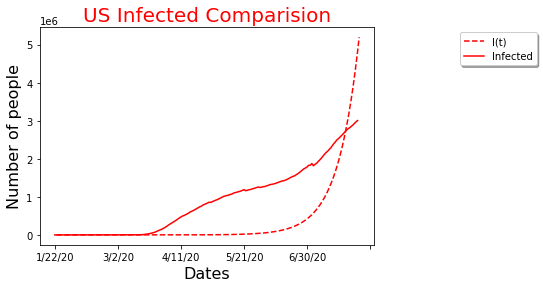

In [ ]:
plt.plot(t, solution[:, 1], '--', label ='I(t)', color = 'red')
plt.plot(SIRD_df['SIRD_Infected'], label='Infected', color= 'red')


plt.title(location + " Infected Comparision", size =20, color = 'red')
plt.xticks(x_val)
plt.xlabel("Dates", size =16)
plt.ylabel("Number of people", size=16)
plt.legend(prop = {'size':10}, loc='upper right', fancybox=True, shadow=True, bbox_to_anchor=(1.5, 1))
plt.show()

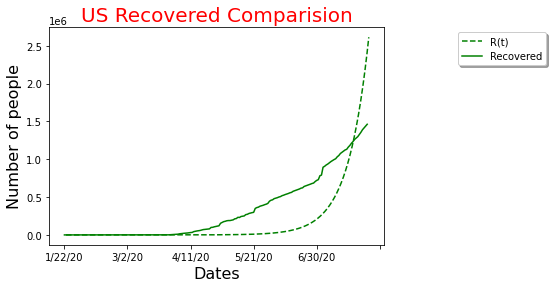

In [ ]:
plt.plot(t, solution[:, 2], '--', label ='R(t)', color = 'green')
plt.plot(SIRD_df['SIRD_Recovered'], label='Recovered', color= 'green')

plt.title(location + " Recovered Comparision", size =20, color = 'red')
plt.xticks(x_val)
plt.xlabel("Dates", size =16)
plt.ylabel("Number of people", size=16)
plt.legend(prop = {'size':10}, loc='upper right', fancybox=True, shadow=True, bbox_to_anchor=(1.5, 1))
plt.show()

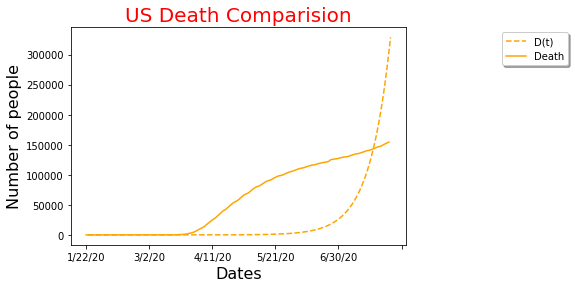

In [ ]:
plt.plot(t, solution[:, 3], '--', label ='D(t)', color = 'orange')
plt.plot(SIRD_df['SIRD_Death'], label='Death', color= 'orange')

plt.title(location + " Death Comparision", size =20, color = 'red')
plt.xticks(x_val)
plt.xlabel("Dates", size =16)
plt.ylabel("Number of people", size=16)
plt.legend(prop = {'size':10}, loc='upper right', fancybox=True, shadow=True, bbox_to_anchor=(1.5, 1))
plt.show()

**9. Build Neural Network**

In [ ]:
I_arr=np.array(SIRD_df["SIRD_Infected"])
R_arr=np.array(SIRD_df['SIRD_Recovered'])
D_arr=np.array(SIRD_df['SIRD_Death'])
X=np.stack([I_arr, R_arr, D_arr], axis=1)
X=np.delete(X, [0,1], axis=0)
print(X.shape)

(191, 3)


In [ ]:
X_train, X_test =train_test_split(X, train_size=0.9, shuffle= False )
print(X_train.shape, X_test.shape)

(171, 3) (20, 3)


In [ ]:
X_test=np.vstack([X_train, X_test[0]])
print(X_test.shape)

(172, 3)


In [ ]:
class NeuralNetwork:
    def __init__(self, x, y, population):
        self.x = x
        self.y = y
        self.population = population

    def predict(self,test):
        self.cal_const()
        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()
        scaler_x.fit(self.x)
        xscale=scaler_x.transform(self.x)
        scaler_y.fit(self.out)
        yscale=scaler_y.transform(self.out)
       
        model = Sequential()
        model.add(Dense(8,activation='sigmoid',input_dim=3))
        model.add(Dense(3,activation='sigmoid'))
     
        model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
        model.summary()
        

        history = model.fit(xscale, yscale, epochs=2000, batch_size=1, verbose=0, validation_split=0.2)
        
        #self.plot_history(history)

        print(model.evaluate(self.x, self.out))

        scaler_test = MinMaxScaler()
        scaler_test.fit(test)
        test_scale = scaler_test.transform(test)
        y_predict= model.predict(test_scale)
        y_predict = scaler_y.inverse_transform(y_predict)
        return y_predict

    def cal_const(self):
        out = []
        for i in range(self.y.shape[0]):
          if(i<self.y.shape[0]-1):
            #self.x[i][0]:I
            #self.x[i][1]:R
            #self.x[i][2]:D
            if (self.y[i][2] != 0):
              mu = (self.y[i+1][2] - self.y[i][2])/self.y[i][2]
            else: 
              mu = Mu
            if (self.x[i][1] != 0):
              gama = (self.y[i+1][1] - self.y[i][1])/self.y[i][1]
            else:
              gamma = Gamma
            if (self.y[i][1] !=0):
              Si = self.population-(self.y[i][0] + self.y[i][1] + self.y[i][2])
              Si_1 = self.population-(self.y[i+1][0] + self.y[i+1][1] + self.y[i+1][2])
              beta = ((Si - Si_1)/(Si*self.y[i][0]))*self.population
            else: 
              beta = Beta
            out.append([beta, gamma, mu])
        self.out = np.array(out)
    def plot_history(self, history):
      
      # Render the loss.
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train', 'test'], loc='upper left')
      plt.show()
      plt.clf()


In [ ]:
neuron = NeuralNetwork(X_train, X_test, population)
predict_alpha = neuron.predict(X)


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 8)                 32        
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 27        
Total params: 59
Trainable params: 59
Non-trainable params: 0
_________________________________________________________________
171/171 [==============================] - 0s 44us/step
[0.08905506489848805, 0.32163742184638977]


In [ ]:
print(predict_alpha)

[[0.22583707 0.03806055 0.18550903]
 [0.22583707 0.03806055 0.18550903]
 [0.22583804 0.03806055 0.18551126]
 [0.22583804 0.03806055 0.18551126]
 [0.22583804 0.03806055 0.18551126]
 [0.22583804 0.03806055 0.18551126]
 [0.22583804 0.03806055 0.18551126]
 [0.22583866 0.03806055 0.1855129 ]
 [0.22583894 0.03806055 0.1855138 ]
 [0.22583894 0.03806055 0.1855138 ]
 [0.22583988 0.03806055 0.18551618]
 [0.22583988 0.03806055 0.18551618]
 [0.22583988 0.03806055 0.18551618]
 [0.22583988 0.03806055 0.18551618]
 [0.22583988 0.03806055 0.18551618]
 [0.22583988 0.03806055 0.18551618]
 [0.22582623 0.03806055 0.18549994]
 [0.22582623 0.03806055 0.18549994]
 [0.22582655 0.03806055 0.18550068]
 [0.22582655 0.03806055 0.18550068]
 [0.22582686 0.03806055 0.18550158]
 [0.22582686 0.03806055 0.18550158]
 [0.22582686 0.03806055 0.18550158]
 [0.22582686 0.03806055 0.18550158]
 [0.22582686 0.03806055 0.18550158]
 [0.22582686 0.03806055 0.18550158]
 [0.22582686 0.03806055 0.18550158]
 [0.22582686 0.03806055 0.18

In [ ]:
R0=[]
for i in range(predict_alpha.shape[0]):
  R_0 = predict_alpha[i, 0]/(predict_alpha[i, 1]+ predict_alpha[i, 2])
  R0.append(R_0)

print(R0)

[1.0101422, 1.0101422, 1.0101365, 1.0101365, 1.0101365, 1.0101365, 1.0101365, 1.0101318, 1.0101291, 1.0101291, 1.0101225, 1.0101225, 1.0101225, 1.0101225, 1.0101225, 1.0101225, 1.0101348, 1.0101348, 1.0101329, 1.0101329, 1.0101303, 1.0101303, 1.0101303, 1.0101303, 1.0101303, 1.0101303, 1.0101303, 1.0101303, 1.010135, 1.010135, 1.0101348, 1.0101348, 1.0101396, 1.0101396, 1.0101374, 1.01014, 1.0101347, 1.0101212, 1.0101292, 1.010097, 1.010073, 1.0099306, 1.0098467, 1.0096246, 1.0094194, 1.0092789, 1.0089262, 1.0080993, 1.0072297, 1.0060139, 1.0045056, 1.0044297, 1.001695, 0.9981782, 0.99314964, 0.982802, 0.9727099, 0.96064764, 0.9460678, 0.92804676, 0.91146654, 0.8925525, 0.865772, 0.84107447, 0.8159645, 0.7962083, 0.7771858, 0.7518029, 0.72814965, 0.7008052, 0.673721, 0.6484214, 0.6284024, 0.60865957, 0.590196, 0.57291853, 0.5558986, 0.5409192, 0.52949226, 0.51989025, 0.5109327, 0.50547546, 0.50115514, 0.49610716, 0.49315688, 0.4924094, 0.48916927, 0.48712802, 0.48859692, 0.4892294, 0.4

**10. Plot the result of Beta, Gamma, Mu, R0**

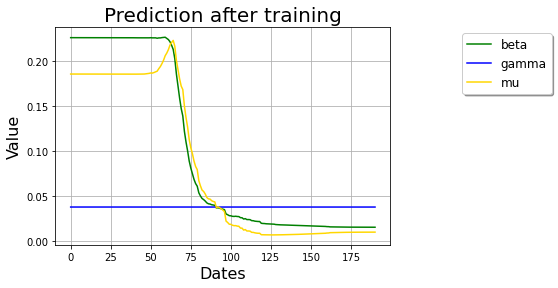

In [ ]:
plt.plot(predict_alpha[:,0], label='beta', color= 'green')
plt.plot(predict_alpha[:,1], label='gamma', color= 'blue')
plt.plot(predict_alpha[:,2], label='mu', color= 'gold')
plt.grid()
plt.title("Prediction after training", size =20)
plt.xlabel("Dates", size =16)
plt.ylabel("Value", size=16)
plt.legend(prop = {'size':12}, loc='upper right', fancybox=True, shadow=True, bbox_to_anchor=(1.5, 1))
plt.show()

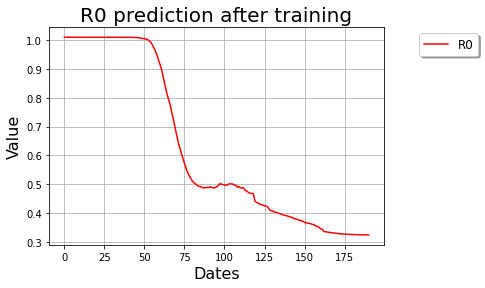

In [ ]:
plt.plot(R0, label='R0', color= 'red')
plt.title("R0 prediction after training", size =20)
plt.grid()
plt.xlabel("Dates", size =16)
plt.ylabel("Value", size=16)
plt.legend(prop = {'size':12}, loc='upper right', fancybox=True, shadow=True, bbox_to_anchor=(1.3, 1))
plt.show()

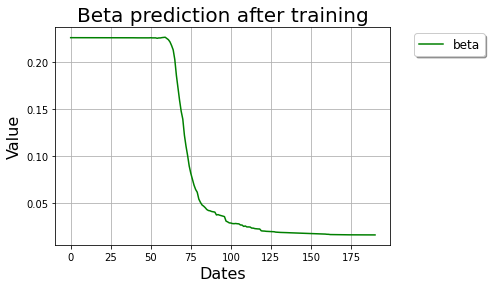

In [ ]:
plt.plot(predict_alpha[:,0], label='beta', color= 'green')
plt.grid()
plt.title("Beta prediction after training", size =20)
plt.xlabel("Dates", size =16)
plt.ylabel("Value", size=16)
plt.legend(prop = {'size':12}, loc='upper right', fancybox=True, shadow=True, bbox_to_anchor=(1.3, 1))
plt.show()

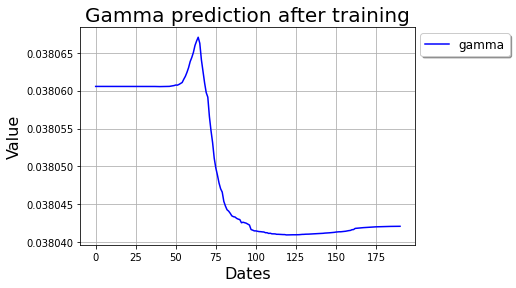

In [ ]:
plt.plot(predict_alpha[:,1], label='gamma', color= 'blue')
plt.grid()
plt.title("Gamma prediction after training", size =20)
plt.xlabel("Dates", size =16)
plt.ylabel("Value", size=16)
plt.legend(prop = {'size':12}, loc='upper right', fancybox=True, shadow=True, bbox_to_anchor=(1.3, 1))
plt.show()

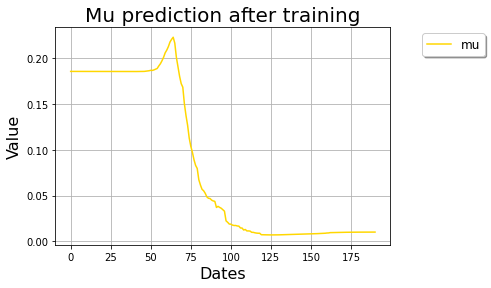

In [ ]:
plt.plot(predict_alpha[:,2], label='mu', color= 'gold')
plt.grid()
plt.title("Mu prediction after training", size =20)
plt.xlabel("Dates", size =16)
plt.ylabel("Value", size=16)
plt.legend(prop = {'size':12}, loc='upper right', fancybox=True, shadow=True, bbox_to_anchor=(1.3, 1))
plt.show()